# Setup

In [1]:
# Install and import necessary packages and libraries
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,Input, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from scikeras.wrappers import KerasClassifier

In [2]:
# Version information
print("Versions of imported packages:")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"scikit-learn: {tf.__version__}")


Versions of imported packages:
Num GPUs Available:  1
numpy: 1.24.3
pandas: 2.0.3
seaborn: 0.13.2
matplotlib: 3.7.2
tensorflow: 2.10.0
scikit-learn: 2.10.0


# Loading Data

In [3]:
# loading data
with open('data/emnist_train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('data/emnist_test.pkl', 'rb') as f:
    test_data = pickle.load(f)

x_train = train_data['data']
y_train = train_data['labels']

x_test = test_data['data']
y_test = test_data['labels']

print("Training data:", x_train.shape)
print("Training labels:", y_train.shape)
print("Test data:", x_test.shape)
print("Test labels:", y_test.shape)

Training data: (100000, 28, 28)
Training labels: (100000,)
Test data: (20000, 28, 28)
Test labels: (20000,)


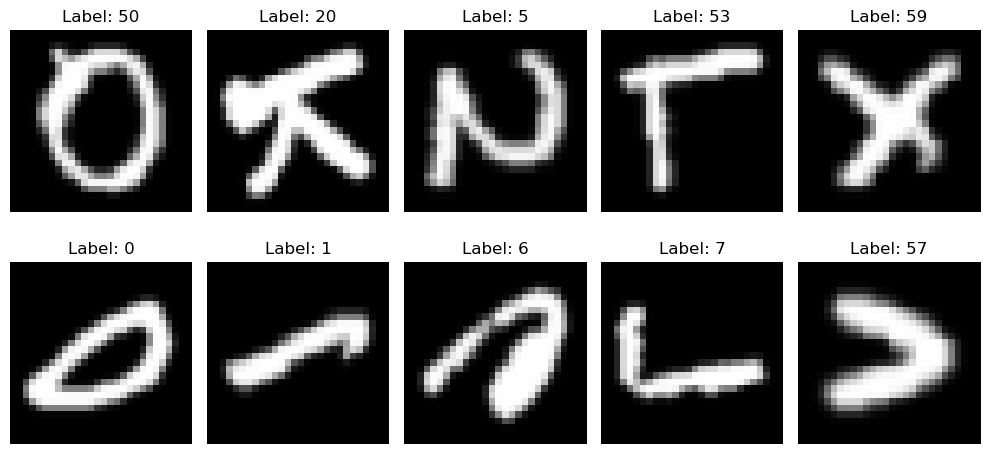

In [4]:
# show some data
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2 rows and 5 columns displaying 10 images

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap='gray')  # Display the ith image, using greyscale colour mapping
    ax.set_title(f"Label: {y_train[i]}")  # Showing corresponding tags
    ax.axis('off')  # no axes

plt.tight_layout()  
plt.show() 

# Pre-processing

In [5]:
def preprocess_data(x_train, y_train, x_test, y_test, num_classes=62, validation_split=0.2, one_hot_encode=True):

    # Reshape training and test data for grayscale: (num_samples, 28, 28, 1)
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
    
    # Normalize the training and test data 
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    # Optional One-hot coded labels
    if one_hot_encode:
        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

    # split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_split, random_state=42)
    
    # show the results
    print("\nAfter preprocessing:")
    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [6]:
# EMNIST has 62 classes
num_classes=62

# Model Implementation

## Model 1: Convolutional Neural Network (CNN)

### Model Implementation

In [7]:
# Getting pre-processed data
x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn = preprocess_data(x_train, y_train, x_test, y_test, one_hot_encode=True)



After preprocessing:
x_train shape: (80000, 28, 28, 1)
y_train shape: (80000, 62)
x_val shape: (20000, 28, 28, 1)
y_val shape: (20000, 62)
x_test shape: (20000, 28, 28, 1)
y_test shape: (20000, 62)


In [8]:
# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Fit the datagen on the training data
datagen.fit(x_train_cnn)

print("\nData augmentation generator is ready to use during model training.")


Data augmentation generator is ready to use during model training.


In [9]:
# Model Implementation

model_cnn = Sequential()

# Convolutional Layer 1
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())

# Convolutional Layer 2
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())

# Flatten and Dense Layers
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                        

In [10]:
# Function to create model, required for KerasClassifier
def create_cnn_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


### Hyperparameter Tunning

In [12]:
# Hyperparameter tuning for the CNN model
# Wrap the model using the function you have created
model_cnn_cv = KerasClassifier(build_fn=create_cnn_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [64, 128],
    'epochs': [5],  # Set to a low number for demonstration purposes
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5]
}

# Create Grid Search
grid_cnn = GridSearchCV(estimator=model_cnn_cv, param_grid=param_grid, n_jobs=1, cv=3)

# Fit the grid search
# Note: This process will take a considerable amount of time
grid_result_cnn = grid_cnn.fit(x_train_cnn, y_train_cnn)

# Summarize results
print("Best: %f using %s" % (grid_result_cnn.best_score_, grid_result_cnn.best_params_))

C:\Users\F0rR1ver\AppData\Local\Temp\ipykernel_30828\890626091.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_cnn_cv = KerasClassifier(build_fn=create_cnn_model, verbose=0)


Best: 0.842212 using {'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 5, 'optimizer': 'adam'}


In [34]:
# Extract the best parameters
best_params_cnn = grid_result_cnn.best_params_
print("Best Parameters:", best_params_cnn)

# Create a new model with the best parameters
model_cnn_best = create_cnn_model(optimizer=best_params_cnn['optimizer'], dropout_rate=best_params_cnn['dropout_rate'])

# Train the model with the training data
history_cnn = model_cnn_best.fit(
    x_train_cnn, y_train_cnn,
    batch_size=best_params_cnn['batch_size'],
    epochs=10,  # Increase the number of epochs for better performance
    validation_split=0.1,
    verbose=1
)

Best Parameters: {'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 5, 'optimizer': 'adam'}
Epoch 1/10
563/563 [==============================] - 2s 3ms/step - loss: 0.9707 - accuracy: 0.7207 - val_loss: 1.0317 - val_accuracy: 0.6676
Epoch 2/10
563/563 [==============================] - 2s 3ms/step - loss: 0.5734 - accuracy: 0.8078 - val_loss: 0.4894 - val_accuracy: 0.8304
Epoch 3/10
563/563 [==============================] - 2s 3ms/step - loss: 0.4854 - accuracy: 0.8303 - val_loss: 0.4533 - val_accuracy: 0.8443
Epoch 4/10
563/563 [==============================] - 2s 3ms/step - loss: 0.4445 - accuracy: 0.8420 - val_loss: 0.4465 - val_accuracy: 0.8443
Epoch 5/10
563/563 [==============================] - 2s 3ms/step - loss: 0.4164 - accuracy: 0.8479 - val_loss: 0.4529 - val_accuracy: 0.8438
Epoch 6/10
563/563 [==============================] - 2s 3ms/step - loss: 0.3907 - accuracy: 0.8565 - val_loss: 0.4432 - val_accuracy: 0.8471
Epoch 7/10
563/563 [==============================] - 1s

## Model 2: RNN

### Model Implementation

In [14]:
# Getting pre-processed data
x_train_rnn, y_train_rnn, x_val_rnn, y_val_rnn, x_test_rnn, y_test_rnn = preprocess_data(x_train, y_train, x_test, y_test, one_hot_encode=True)


After preprocessing:
x_train shape: (80000, 28, 28, 1)
y_train shape: (80000, 62)
x_val shape: (20000, 28, 28, 1)
y_val shape: (20000, 62)
x_test shape: (20000, 28, 28, 1)
y_test shape: (20000, 62)


In [17]:
# Design RNN Model
def create_rnn_model(learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    # LSTM
    model.add(LSTM(128, return_sequences=False))
    model.add(BatchNormalization())
    # Dropout
    model.add(Dropout(0.5))
    # Dense
    model.add(Dense(128, activation='relu'))
    # Dropout
    model.add(Dropout(0.5))
    # Output
    model.add(Dense(62, activation='softmax'))
    # Compile
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Hyperparameter Tunning

In [21]:
rnn_model = KerasClassifier(build_fn=create_rnn_model, verbose=0)
param_grid_rnn = {
    'batch_size': [64, 128],
    'epochs': [5],
    'learning_rate': [0.001, 0.0001],
}
grid_search_rnn = GridSearchCV(estimator=rnn_model, param_grid=param_grid_rnn, cv=3, verbose=2, n_jobs=1)
grid_result_rnn = grid_search_rnn.fit(x_train_rnn, y_train_rnn)
print(f"best params: {grid_result_rnn.best_params_}")

C:\Users\F0rR1ver\AppData\Local\Temp\ipykernel_30828\1422443469.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = KerasClassifier(build_fn=create_rnn_model, verbose=0)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......batch_size=64, epochs=5, learning_rate=0.001; total time=  22.6s
[CV] END .......batch_size=64, epochs=5, learning_rate=0.001; total time=  22.0s
[CV] END .......batch_size=64, epochs=5, learning_rate=0.001; total time=  22.0s
[CV] END ......batch_size=64, epochs=5, learning_rate=0.0001; total time=  22.2s
[CV] END ......batch_size=64, epochs=5, learning_rate=0.0001; total time=  22.4s
[CV] END ......batch_size=64, epochs=5, learning_rate=0.0001; total time=  22.1s
[CV] END ......batch_size=128, epochs=5, learning_rate=0.001; total time=  12.4s
[CV] END ......batch_size=128, epochs=5, learning_rate=0.001; total time=  12.7s
[CV] END ......batch_size=128, epochs=5, learning_rate=0.001; total time=  12.5s
[CV] END .....batch_size=128, epochs=5, learning_rate=0.0001; total time=  12.4s
[CV] END .....batch_size=128, epochs=5, learning_rate=0.0001; total time=  12.6s
[CV] END .....batch_size=128, epochs=5, learning_

In [22]:
# best_params_rnn = grid_result_rnn.best_params_
best_params_rnn = {'batch_size': 64, 'epochs': 10, 'model__learning_rate': 0.001}
best_rnn = create_rnn_model(learning_rate=best_params_rnn['model__learning_rate'])
best_rnn.summary()
history_rnn = best_rnn.fit(x_train_rnn, y_train_rnn,
                          validation_data=(x_val_rnn, y_val_rnn),
                          epochs=best_params_rnn['epochs'],
                          batch_size=best_params_rnn['batch_size'])

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 128)               80384     
                                                                 
 batch_normalization_117 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_78 (Dropout)        (None, 128)               0         
                                                                 
 dense_130 (Dense)           (None, 128)               16512     
                                                                 
 dropout_79 (Dropout)        (None, 128)               0         
                                                                 
 dense_131 (Dense)           (None, 62)                7998      
                                                     

## Model 3: Transformer

### Model Implementation

In [23]:
# Getting pre-processed data
x_train_vit, y_train_vit, x_val_vit, y_val_vit, x_test_vit, y_test_vit = preprocess_data(x_train, y_train, x_test, y_test, one_hot_encode=False)


After preprocessing:
x_train shape: (80000, 28, 28, 1)
y_train shape: (80000,)
x_val shape: (20000, 28, 28, 1)
y_val shape: (20000,)
x_test shape: (20000, 28, 28, 1)
y_test shape: (20000,)


In [24]:
# Implementation vision transformer
class vit(Model):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout):
        super(vit, self).__init__()

        # Calculate the total number of patches in the image
        # If the image size is 28x28 and the patch size is 4, then num_patches = (28 // 4) ** 2 = 49
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = patch_size * patch_size  # Number of pixels per patch

        # Patch embedding layer: transforms each patch into a dim-dimensional feature vector
        self.patch_embedding = layers.Dense(dim)
        
        # Location embedding for learning the relative position of each patch in the image
        self.position_embedding = layers.Embedding(input_dim=num_patches + 1, output_dim=dim)
        
        # Classification token (class token) to indicate the class of the image; randomly initialised to a trainable variable
        self.cls_token = tf.Variable(tf.zeros([1, 1, dim]), trainable=True)

        # Transformer coding layers
        # Each transformer layer contains a MultiHeadAttention mechanism, a Layer Normalisation Layer and an MLP Layer
        # layers.MultiHeadAttention performs multi-head self-attention computation
        self.transformer_layers = [
            layers.MultiHeadAttention(num_heads=heads, key_dim=dim, dropout=dropout) for _ in range(depth)
        ]
        
        # Layer normalisation before each transformer layer
        self.norm_layers = [layers.LayerNormalization(epsilon=1e-6) for _ in range(depth)]
        
        # Small MLP networks behind each transformer layer
        self.mlp_layers = [tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),  # Hidden Layers for MLP
            layers.Dropout(dropout),                   # Dropout prevents overfitting
            layers.Dense(dim),                         # Output to dim dimension for easy residual linking
            layers.Dropout(dropout)
        ]) for _ in range(depth)]

        # Category header: output scores for each category
        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),   # Layer normalisation before output
            layers.Dense(num_classes)                  # Output layer with dimension num_classes
        ])

    def call(self, x):
        # Get batch size
        batch_size = tf.shape(x)[0]
        
        # Divide the input image into patches
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, 4, 4, 1],          
            strides=[1, 4, 4, 1],        
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(patches, [batch_size, -1, 4 * 4])  # Flatten each patch into one dimension

        # Apply patch embedding to transform each patch into a dim-dimensional feature vector
        x = self.patch_embedding(patches)

        # Extend the size of the classification markers to the batch
        cls_tokens = tf.repeat(self.cls_token, repeats=batch_size, axis=0)
        
        # Splice classification markers in front of patch features
        x = tf.concat([cls_tokens, x], axis=1)
        
        # Add positional embedding to indicate the relative position of each patch
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        x += self.position_embedding(positions)

        # Transformer encoder part
        # Each transformer layer undergoes a layer of normalisation, a multi-head attention mechanism, and an MLP layer
        for norm_layer, transformer_layer, mlp_layer in zip(self.norm_layers, self.transformer_layers, self.mlp_layers):
            x = norm_layer(x)
            x = transformer_layer(x, x) + x
            x = mlp_layer(x) + x

        # Classification predictions using only classified labelled features
        x = x[:, 0]  
        return self.mlp_head(x)  
    
# Reference:
# https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras/
# https://blog.csdn.net/qq_37541097/article/details/118242600
# https://github.com/WZMIAOMIAO/deep-learning-for-image-processing?tab=readme-ov-file


In [25]:
# Construct the Vision Transformer model and compile it.
def build_vit_model(image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout):
    model = vit(image_size=image_size, 
                patch_size=patch_size, 
                num_classes=num_classes, 
                dim=dim, 
                depth=depth, 
                heads=heads, 
                mlp_dim=mlp_dim, 
                dropout=dropout)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
                  metrics=['accuracy'])
    return model

# Reference:
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [36]:
# Model testing with given parameters
test_model_vit = build_vit_model(image_size=28, patch_size=4, num_classes=num_classes, dim=64, depth=4, heads=4, mlp_dim=128, dropout=0.1)

test_model_vit.fit(x_train_vit, y_train_vit, batch_size=64, epochs=10, validation_data=(x_val_vit, y_val_vit))

Epoch 1/10
1250/1250 [==============================] - 16s 12ms/step - loss: 1.6962 - accuracy: 0.5297 - val_loss: 0.9745 - val_accuracy: 0.6914
Epoch 2/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8824 - accuracy: 0.7218 - val_loss: 0.7341 - val_accuracy: 0.7558
Epoch 3/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7293 - accuracy: 0.7622 - val_loss: 0.6431 - val_accuracy: 0.7834
Epoch 4/10
1250/1250 [==============================] - 14s 12ms/step - loss: 0.6610 - accuracy: 0.7789 - val_loss: 0.5986 - val_accuracy: 0.7959
Epoch 5/10
1250/1250 [==============================] - 14s 12ms/step - loss: 0.6166 - accuracy: 0.7910 - val_loss: 0.5891 - val_accuracy: 0.8002
Epoch 6/10
1250/1250 [==============================] - 14s 12ms/step - loss: 0.5898 - accuracy: 0.7994 - val_loss: 0.5534 - val_accuracy: 0.8086
Epoch 7/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.5580 - accuracy: 0.8069 - val_loss: 0.5446 -

In [27]:
# Display the results of the test
train_loss_test_vit, train_accuracy_test_vit = test_model_vit.evaluate(x_train_vit, y_train_vit)
val_loss_test_vit, val_accuracy_test_vit = test_model_vit.evaluate(x_val_vit, y_val_vit)

print(f"Train Loss: {train_loss_test_vit:.4f}, Train Accuracy: {train_accuracy_test_vit:.4f}")
print(f"Validation Loss: {val_loss_test_vit:.4f}, Validation Accuracy: {val_accuracy_test_vit:.4f}")

625/625 [==============================] - 4s 6ms/step - loss: 0.5005 - accuracy: 0.8255
Train Loss: 0.4356, Train Accuracy: 0.8430
Validation Loss: 0.5005, Validation Accuracy: 0.8255


### Hyperparameter Tunning

In [28]:
# Wrapping the build_vit_model function with KerasClassifier for compatibility with scikit-learn's RandomisedSearchCV
model_vit = KerasClassifier(build_fn=build_vit_model, epochs=5, batch_size=64, verbose=0)

# Defining the Hyperparameter
param_dist_vit = {
    'image_size': [28],
    'patch_size': [2, 4, 7],
    'num_classes':[62],
    'dim': [32, 64, 128],
    'depth': [4, 6, 8],
    'heads': [4, 8],
    'mlp_dim': [64, 128, 256],
    'dropout': [0.1, 0.2, 0.3]
}

# Use Randomized Search + Cross-Validation
random_search_vit = RandomizedSearchCV(
    estimator=model_vit,
    param_distributions=param_dist_vit,
    n_iter=10,
    scoring='accuracy',
    cv=3
)

C:\Users\F0rR1ver\AppData\Local\Temp\ipykernel_30828\1204293435.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_vit = KerasClassifier(build_fn=build_vit_model, epochs=5, batch_size=64, verbose=0)


In [29]:
random_search_vit.fit(x_train_vit, y_train_vit)

print("Best Parameters:", random_search_vit.best_params_)
print("Best Score:", random_search_vit.best_score_)

834/834 [==============================] - 7s 8ms/step
Best Parameters: {'patch_size': 4, 'num_classes': 62, 'mlp_dim': 256, 'image_size': 28, 'heads': 4, 'dropout': 0.2, 'dim': 128, 'depth': 4}
Best Score: 0.7580751247697082


In [37]:
best_params_vit = {'patch_size': 4, 'num_classes': 62, 'mlp_dim': 256, 'image_size': 28, 'heads': 4, 'dropout': 0.2, 'dim': 128, 'depth': 4}

# Create a new model with the best parameters
final_model_vit = build_vit_model(
    image_size=best_params_vit['image_size'],
    patch_size=best_params_vit['patch_size'],
    num_classes=best_params_vit['num_classes'],
    dim=best_params_vit['dim'],
    depth=best_params_vit['depth'],
    heads=best_params_vit['heads'],
    mlp_dim=best_params_vit['mlp_dim'],
    dropout=best_params_vit['dropout']
)

# Train the model with the training data
history_vit = final_model_vit.fit(
    x_train_vit, y_train_vit,
    batch_size=64,
    epochs=30,  
    validation_data=(x_val_vit, y_val_vit)
)

Epoch 1/30
1250/1250 [==============================] - 18s 13ms/step - loss: 1.7103 - accuracy: 0.5199 - val_loss: 0.9820 - val_accuracy: 0.6979
Epoch 2/30
1250/1250 [==============================] - 16s 12ms/step - loss: 0.9670 - accuracy: 0.6944 - val_loss: 0.8064 - val_accuracy: 0.7350
Epoch 3/30
1250/1250 [==============================] - 16s 12ms/step - loss: 0.8297 - accuracy: 0.7324 - val_loss: 0.7275 - val_accuracy: 0.7541
Epoch 4/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.7532 - accuracy: 0.7538 - val_loss: 0.6667 - val_accuracy: 0.7769
Epoch 5/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.7055 - accuracy: 0.7670 - val_loss: 0.6529 - val_accuracy: 0.7789
Epoch 6/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6678 - accuracy: 0.7766 - val_loss: 0.6884 - val_accuracy: 0.7728
Epoch 7/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6357 - accuracy: 0.7854 - val_loss: 0.6331 -